In [3]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [4]:
import huggingface_hub as hub
all_datasets = [ds.id for ds in hub.list_datasets()]
print(f'There are {len(all_datasets)} datasets currently available on the Hub')
print(f"The first 10 are {all_datasets[:10]}")

There are 10908 datasets currently available on the Hub
The first 10 are ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [5]:
from datasets import load_dataset
emotions = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (C:\Users\61417\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)
100%|██████████| 3/3 [00:00<00:00, 153.83it/s]


In [6]:
train_ds = emotions['train']
# train_ds.features


In [7]:
import pandas as pd

emotions.set_format(type = 'pandas') # hugging face datasets uses a columnar datatype
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
def label_int2str(row):
    # features["label"] returns a dict with label names
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


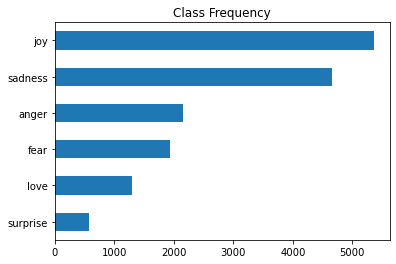

In [9]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending = True).plot.barh()
plt.title("Class Frequency")
plt.show()

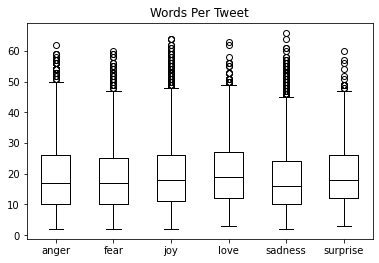

In [10]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by = "label_name", grid = False,
color = "black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [11]:
emotions.reset_format()

In [12]:
# subword tokenization
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [13]:
text = "Tokinizing text is a core task of NLP."

encoded_text = tokenizer(text)
print(encoded_text)

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

print(tokenizer.convert_tokens_to_string(tokens))

## when using pre-trained models it is really important to make sure that you use the same tokenizer that the model was trained with

{'input_ids': [101, 2000, 4939, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'to', '##kin', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
[CLS] tokinizing text is a core task of nlp. [SEP]


In [246]:
# tokenizing the whole dataset

def tokenize(batch):
    return tokenizer(batch["text"], padding = True, truncation = True)

# print(tokenize(emotions["train"][:2]))
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)
print(emotions_encoded["train"].column_names)

100%|██████████| 1/1 [00:00<00:00,  9.62ba/s]

['text', 'label', 'input_ids', 'attention_mask']


In [15]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [16]:
from transformers import AutoModel
import torch

# same as before
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
text = "this is a test"
inputs = tokenizer(text, return_tensors = "pt") # pt for pytorch
print(f"inputs tensor shape: {inputs['input_ids'].size()}") #[batch_size, n_tokens]
print(tokenizer.convert_ids_to_tokens(inputs.input_ids[0]))


inputs tensor shape: torch.Size([1, 6])
['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']


In [18]:
[type(v) for k,v in inputs.items()]

[torch.Tensor, torch.Tensor]

In [53]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [56]:
# in practice, we often use the hidden state of the last input token in the sequence (the [CLS] token at index 0)
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [57]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
                if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch",
                            columns = ["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched = True)

100%|██████████| 2/2 [01:36<00:00, 48.45s/ba]


In [2]:
import datasets
# emotions_hidden.save_to_disk("test.hf")
emotions_hidden = datasets.load_from_disk('./test.hf')

In [3]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

(16000, 768) (2000, 768)


In [7]:
# visualising the training set
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)

# initialized and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
#Create a df of 2d embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns = ['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()


,X,Y,label
0,4.476506,6.354021,0
1,-2.777670,5.481840,0
2,5.310009,2.831295,3
3,-2.076781,3.289207,2
4,-3.141330,3.396249,3


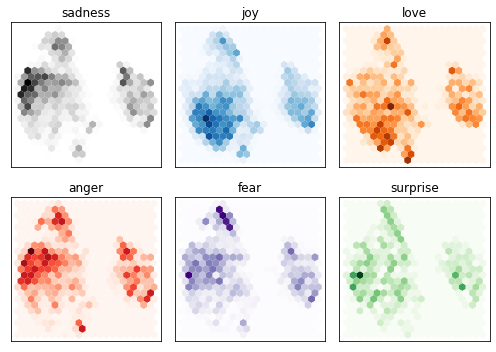

In [11]:
fig, axes = plt.subplots(2, 3, figsize = (7, 5))
axes = axes.flatten()

cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap = cmap, gridsize = 20, linewidths = (0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [12]:
from sklearn.linear_model import LogisticRegression


LR = LogisticRegression(max_iter = 3000)
LR.fit(X_train, y_train)
LR.score(X_valid, y_valid)

0.633

In [13]:
from sklearn.dummy import DummyClassifier

Dy = DummyClassifier(strategy = 'most_frequent')
Dy.fit(X_train, y_train)
Dy.score(X_valid, y_valid)

0.352

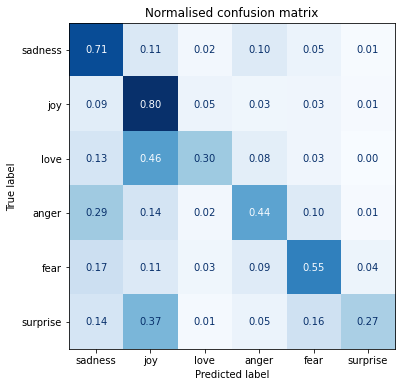

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize = "true")
    fig, ax = plt.subplots(figsize = (6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(cmap = 'Blues', values_format = ".2f", ax = ax, colorbar = False)
    plt.title("Normalised confusion matrix")
    plt.show()

y_preds = LR.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [159]:
LR.coef_.shape

(6, 768)

In [232]:
import torch
from torch import nn

class NNLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NNLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim*10)
        self.linear2 = torch.nn.Linear(output_dim * 10, output_dim)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        return x


def Train(net, epochs, X_train, y_train, criterion, optimizer):

    iter = 0
    running_loss = 0
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        outputs = net(X_train)
        loss = criterion(torch.squeeze(outputs), y_train.long())

        loss.backward()
        optimizer.step()
        iter += 1
        running_loss += loss.item()
        if iter % 100:
            print(f'[{epoch + 1}, {iter:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0 # why reset this? - its an average loss for last 2000 mini batches

# def Train(net, epochs, trainloader, criterion, optimizer):
#     # train the network
#     for epoch in range(epochs):

#         running_loss = 0.0
#         for i, data in enumerate(trainloader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels = data

#             # zero the parameter gradients (still not sure what this is really?)
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs)
#             loss = criterion(outputs, labels.long())
#             loss.backward()
#             optimizer.step()

#             # print stats
#             running_loss += loss.item()
#             if i % 2000 == 1999: # print every 2000 minibatches
#                 print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
#                 running_loss = 0.0 # why reset this? - its an average loss for last 2000 mini batches


    print('Finished Training')


def Eval(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network: {100 * correct // total} %')




In [233]:
import torch.optim as optim
net = NNLogisticRegression(768, 6)
# cross-entropy loss, use SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

In [234]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

bs = 200

train_ds = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_dl = DataLoader(train_ds, batch_size = bs)

valid_ds = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
valid_dl = DataLoader(valid_ds, batch_size = bs * 2)


In [239]:
Train(net, 500, torch.Tensor(X_train), torch.Tensor(y_train),criterion,optimizer)

[1,     1] loss: 0.013
[2,     2] loss: 0.013
[3,     3] loss: 0.013
[4,     4] loss: 0.013
[5,     5] loss: 0.013
[6,     6] loss: 0.013
[7,     7] loss: 0.013
[8,     8] loss: 0.013
[9,     9] loss: 0.013
[10,    10] loss: 0.013
[11,    11] loss: 0.013
[12,    12] loss: 0.013
[13,    13] loss: 0.013
[14,    14] loss: 0.013
[15,    15] loss: 0.013
[16,    16] loss: 0.013
[17,    17] loss: 0.013
[18,    18] loss: 0.013
[19,    19] loss: 0.013
[20,    20] loss: 0.013
[21,    21] loss: 0.013
[22,    22] loss: 0.013
[23,    23] loss: 0.013
[24,    24] loss: 0.013
[25,    25] loss: 0.013
[26,    26] loss: 0.013
[27,    27] loss: 0.013
[28,    28] loss: 0.013
[29,    29] loss: 0.013
[30,    30] loss: 0.013
[31,    31] loss: 0.013
[32,    32] loss: 0.013
[33,    33] loss: 0.013
[34,    34] loss: 0.013
[35,    35] loss: 0.013
[36,    36] loss: 0.013
[37,    37] loss: 0.013
[38,    38] loss: 0.013
[39,    39] loss: 0.013
[40,    40] loss: 0.013
[41,    41] loss: 0.013
[42,    42] loss: 0.013
[

In [240]:
correct = 0
with torch.no_grad():
    outputs = net(torch.Tensor(X_valid))
    _, preds = torch.max(outputs, 1)

print((preds.numpy() == y_valid).sum() / y_valid.shape[0])



0.575


In [241]:
from transformers import AutoModelForSequenceClassification


# same as before
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 6


model = (AutoModelForSequenceClassification \
    .from_pretrained(model_ckpt, num_labels = num_labels) \
        .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [249]:
# establish performance metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}




In [247]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir = model_name,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    evaluation_strategy = "epoch",
    disable_tqdm = False,
    logging_steps = logging_steps,
    push_to_hub = False,
    log_level = "error"
)



In [251]:
# run the model
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotions_encoded["train"],
    eval_dataset = emotions_encoded["validation"],
    tokenizer = tokenizer
)

trainer.train()

c:\Users\61417\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 50%|█████     | 250/500 [57:42<1:06:38, 16.00s/it]

{'loss': 0.8279, 'learning_rate': 1e-05, 'epoch': 1.0}


                                                   
 50%|█████     | 250/500 [59:33<1:06:38, 16.00s/it]

{'eval_loss': 0.32436901330947876, 'eval_accuracy': 0.9035, 'eval_f1': 0.9011166763910853, 'eval_runtime': 111.0236, 'eval_samples_per_second': 18.014, 'eval_steps_per_second': 0.288, 'epoch': 1.0}


100%|██████████| 500/500 [1:53:36<00:00, 11.47s/it]  

{'loss': 0.2562, 'learning_rate': 0.0, 'epoch': 2.0}


                                                   
100%|██████████| 500/500 [1:55:16<00:00, 13.83s/it]

{'eval_loss': 0.22504207491874695, 'eval_accuracy': 0.9215, 'eval_f1': 0.9213416641463533, 'eval_runtime': 97.8434, 'eval_samples_per_second': 20.441, 'eval_steps_per_second': 0.327, 'epoch': 2.0}
{'train_runtime': 6916.0687, 'train_samples_per_second': 4.627, 'train_steps_per_second': 0.072, 'train_loss': 0.5420692138671875, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5420692138671875, metrics={'train_runtime': 6916.0687, 'train_samples_per_second': 4.627, 'train_steps_per_second': 0.072, 'train_loss': 0.5420692138671875, 'epoch': 2.0})

100%|██████████| 32/32 [02:31<00:00,  4.73s/it]


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (20).

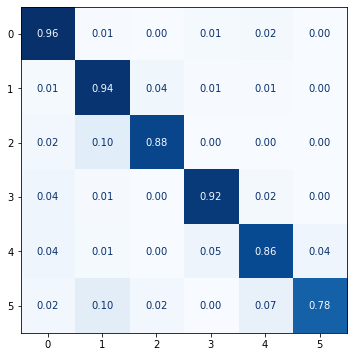

In [252]:
preds_output = trainer.predict(emotions_encoded["validation"])
y_preds = np.argmax(preds_output.predictions, axis = 1)

plot_confusion_matrix(y_preds, y_valid, labels)